<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 2*

# 📝 Assignment
---

In [1]:
%%capture
!pip install -q category_encoders

# 랜덤포레스트(Random Forests)

### 1) 캐글 대회를 이어서 진행합니다. EDA, 데이터 전처리 부분을 업데이트 하세요.
- EDA는 항상 완벽할 수 없지요 한 주간 계속 같은 데이터로 과제를 진행하므로 부족한 부분을 추가하거나 논하세요.
- (지금은 feature engineering에 너무 시간을 들이지 마세요!)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 데이터 불러오기
target = "vacc_h1n1_f"
train = pd.merge(pd.read_csv("train.csv"), pd.read_csv("train_labels.csv")[target], left_index=True, right_index=True)
test = pd.read_csv("test.csv")

In [4]:
# 확인
print(train.shape)
train.tail(2)

(42154, 39)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state,vacc_h1n1_f
42152,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,NaN,NaN,0.0,0.0,NaN,1.0,Somewhat Effective,Somewhat High,Not At All Worried,Very Effective,Somewhat High,Not At All Worried,45 - 54 Years,4.0,3,2,1,1.0,1.0,Employed,3,Non-MSA,2.0,0.0,2.0,Health Care and Social Assistance Industries,Healthcare Practitioners and Technical Occupat...,4,GEORGIA,0
42153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6 Months - 9 Years,NaN,3,2,1,NaN,1.0,NaN,2,"MSA, Not Principle City",2.0,1.0,3.0,NaN,NaN,5,WISCONSIN,0


In [5]:
print(test.shape)
test.tail(2)

(28104, 38)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state
28102,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Somewhat Effective,Very High,Not At All Worried,Very Effective,Very High,Not At All Worried,35 - 44 Years,3.0,4,2,4,1.0,99.0,Employed,2,"MSA, Principle City",2.0,2.0,4.0,Transportation and Warehousing Industries,Office and Administrative Support Occupations,7,NEBRASKA
28103,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,Somewhat Effective,Dont Know,Not Very Worried,Very Effective,Somewhat Low,Not Very Worried,55 - 64 Years,4.0,2,2,2,1.0,1.0,Not in Labor Force,3,Non-MSA,2.0,0.0,2.0,NaN,NaN,4,MISSISSIPPI


In [6]:
# train / validation 데이터셋 분리
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size=0.20, 
                              stratify=train[target], random_state=2)

# 확인
train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [7]:
# feature Matrix / target vaector 분리
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

# 확인
print("feature Matrix: ", X_train.shape, X_val.shape, X_test.shape)
print("target vector: ", y_train.shape, y_val.shape)

feature Matrix:  (33723, 38) (8431, 38) (28104, 38)
target vector:  (33723,) (8431,)


#### 데이터 전처리

In [8]:
# 데이터 타입 및 결측치 확인
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33723 entries, 20365 to 30904
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26933 non-null  float64
 1   h1n1_knowledge               26933 non-null  float64
 2   behavioral_antiviral_meds    26853 non-null  float64
 3   behavioral_avoidance         26731 non-null  float64
 4   behavioral_face_mask         26913 non-null  float64
 5   behavioral_wash_hands        26894 non-null  float64
 6   behavioral_large_gatherings  26866 non-null  float64
 7   behavioral_outside_home      26851 non-null  float64
 8   behavioral_touch_face        26795 non-null  float64
 9   doctor_recc_h1n1             32235 non-null  float64
 10  doctor_recc_seasonal         32235 non-null  float64
 11  chronic_med_condition        32648 non-null  float64
 12  child_under_6_months         26106 non-null  float64
 13  health_insur

데이터 설명과 info를 참고하여 타입 정리

- 순서가 있는 categorical data
    - 숫자형
      
      `h1n1_concern`, `h1n1_knowledge`, `education_comp`, `inc_pov`

    - 문자형

       `opinion_h1n1_vacc_effective`, `opinion_h1n1_risk`, `opinion_h1n1_sick_from_vacc`, `opinion_seas_vacc_effective`, `opinion_seas_sick_from_vacc`, `agegrp`

- 순서가 없는 categorical data
  - 숫자형
      
      `raceeth4_i`, `sex_i`, `marital`, `rent_own_r`, `census_region`, `hhs_region`

  - 문자형

     `census_msa`, `employment_status`, `employment_industry`, `employment_occupation`, `state`

- numeric data

  `n_adult_r`, `household_children`, `n_people_r`, 


- 나머지는 binary

___
tree 모델을 만들 것이기 때문에 ordinal encoding을 하여도 괜찮다. 따라서 데이터 타입을 따로 변경하지는 않았다.

결측치 처리

데이터셋에 대한 설명에 따르면, 위 데이터셋에는 categorical data가 많다. 같은 숫자형이라고 해도 `n_adult_r`, `household_children`, `n_people_r`를 제외하면 모두 categorical, binary data이므로 평균을 내는 게 의미가 없다.일괄적으로 최빈값으로 결측치를 대체하기로 하였다.

In [9]:
# 결측치 최빈값으로 대체
from sklearn.impute import SimpleImputer

# imputer 생성
imputer = SimpleImputer(strategy="most_frequent")

# imputer 적용
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

In [10]:
# 데이터프레임으로 다시 변경
X_train = pd.DataFrame(X_train, columns=features)
X_val = pd.DataFrame(X_val, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

In [11]:
# 결측치 확인
print(X_train.isnull().sum()[X_train.isnull().sum() != 0])
print(X_val.isnull().sum()[X_val.isnull().sum() != 0])
print(X_test.isnull().sum()[X_test.isnull().sum() != 0])

# 모두 제거되었다.

Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


In [12]:
# 새로운 특성 생성 및 컬럼 삭제

def engineering(df):

  # 1) 컬럼 추가: behaviorals중에 해당하는 항목의 수
  behaviorals = [ col for col in train.columns if "behaviorals" in col]
  df["behaviorals"] = df[behaviorals].sum(axis=1)

  # 2) 컬럼 추가: 가구의 구성원 수에서 아동의 수가 차지하는 비율
  df["children_ratio"] = df["household_children"]/df["n_people_r"]

  # 3) 컬럼 삭제: employment가 포함된 컬럼 (결측치가 절반 이상이라 결측치를 어떻게 채워도 정확한 값이 안나올 것 같음)
  dels = [col for col in df.columns if ('employment' in col)]
  df.drop(columns=dels, inplace=True)

  return df

In [13]:
# 함수 적용
X_train = engineering(X_train)
X_val = engineering(X_val)
X_test = engineering(X_test)

In [14]:
# 결과 확인
X_train.head(2)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,state,behaviorals,children_ratio
0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,Somewhat Effective,Somewhat Low,Not At All Worried,Very Effective,Somewhat Low,Not At All Worried,18 - 34 Years,4,3,1,1,2,1,1,"MSA, Not Principle City",4,0,4,2,NEW JERSEY,0.0,0
1,1,1,0,1,0,1,1,1,1,1,1,0,0,1,0,Somewhat Effective,Somewhat High,Not Very Worried,Somewhat Effective,Somewhat Low,Not Very Worried,35 - 44 Years,2,3,2,3,2,2,2,Non-MSA,2,2,4,7,IOWA,0.0,0.5


In [15]:
X_val.head(2)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,state,behaviorals,children_ratio
0,2,1,0,1,0,1,0,0,1,0,0,1,0,1,0,Somewhat Effective,Somewhat Low,Not Very Worried,Somewhat Effective,Somewhat Low,Not At All Worried,6 Months - 9 Years,4,3,1,1,1,1,3,"MSA, Not Principle City",2,2,4,6,OKLAHOMA,0.0,0.5
1,1,2,0,1,0,1,0,0,1,0,0,0,0,1,1,Dont Know,Somewhat Low,Not At All Worried,Very Effective,Somewhat High,Not At All Worried,65+ Years,4,3,2,2,1,1,2,Non-MSA,2,0,2,7,NEBRASKA,0.0,0


In [16]:
X_test.head(2)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,state,behaviorals,children_ratio
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,Not At All Effective,Very Low,Not At All Worried,Not At All Effective,Very Low,Not At All Worried,18 - 34 Years,1,3,2,2,2,1,2,"MSA, Not Principle City",2,0,2,7,KANSAS,0.0,0
1,3,0,0,0,1,1,1,0,0,0,0,0,0,1,0,Dont Know,Dont Know,Dont Know,Dont Know,Dont Know,Dont Know,55 - 64 Years,4,3,1,4,1,1,3,"MSA, Principle City",1,0,1,6,LOUISIANA,0.0,0


#### EDA

어제 살펴보지 않은 항목 위주
- 지역
- 가족 구성원

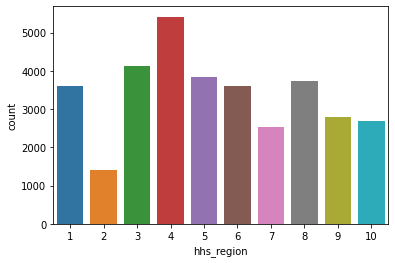

In [17]:
# hhs_region
sns.countplot(x="hhs_region", data=X_train)
plt.show();

각 지역의 인구 수가 대체로 비슷하나, 2번 지역(NJ,NY)만 매우 작았다.

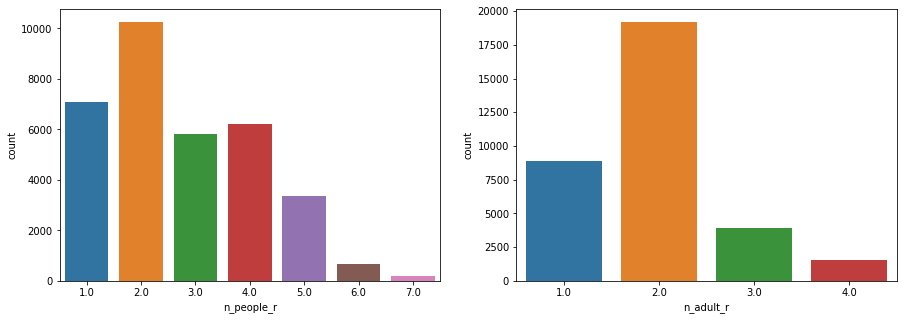

In [18]:
# n_people_r, n_adult_r
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.countplot(x="n_people_r", data=train)

plt.subplot(122)
sns.countplot(x="n_adult_r", data=train)
plt.show();

가구의 구성원 수가 5명 이상인 경우는 있는데, 가구의 어른 수가 5명 이상인 경우는 없는 것으로 보아 5명 이상인 가구는 아이와 함께 산다고 추측할 수 있다.

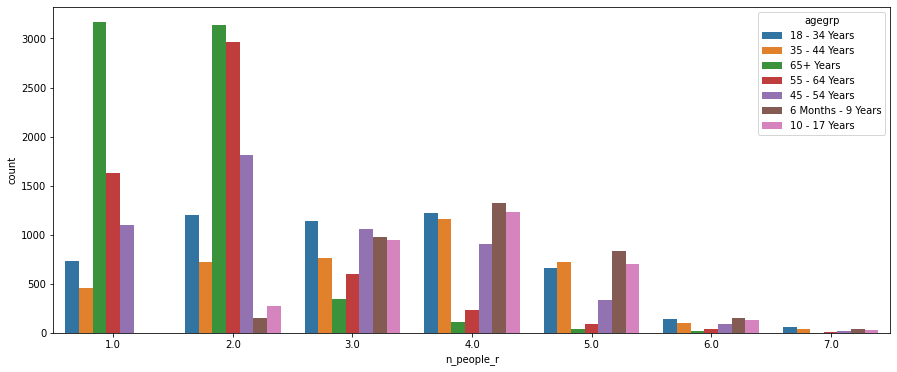

In [19]:
plt.figure(figsize=(15, 6))
sns.countplot(x="n_people_r", data=train, hue="agegrp")
plt.show();

어제 tree model을 만들었을 때 특성 중요도에서 연령대가 65세 이상 여부가 포함되어 있었다. 그래서 오늘 연령대별 가구 구성원 수를 살펴봤는데, 65세 이상의 가구 구성원 수는 대부분 1명 또는 2명이었다.

### 2) Ordinal Encoding을 적용해 보세요.


In [20]:
from category_encoders import OrdinalEncoder

# 인코더 생성
encoder_ordinal = OrdinalEncoder()

# 인코더 적용
X_train_ordinal = encoder_ordinal.fit_transform(X_train)
X_val_ordinal = encoder_ordinal.transform(X_val)
X_test_ordinal = encoder_ordinal.transform(X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
# 크기 비교
print("before encoding")
print(X_train.shape, X_val.shape, X_test.shape)

print("after encoding")
print(X_train_ordinal.shape, X_val_ordinal.shape, X_test_ordinal.shape)

# 크기가 동일하다

before encoding
(33723, 37) (8431, 37) (28104, 37)
after encoding
(33723, 37) (8431, 37) (28104, 37)


In [22]:
# 매핑 결과 일부만 확인
encoder_ordinal.category_mapping[15]

# "opinion_h1n1_risk"의 각 범주가 숫자로 매핑되었음을 확인할 수 있다.

{'col': 'opinion_h1n1_vacc_effective',
 'data_type': dtype('O'),
 'mapping': Somewhat Effective      1
 Not Very Effective      2
 Very Effective          3
 Not At All Effective    4
 Dont Know               5
 Refused                 6
 NaN                    -2
 dtype: int64}

### 3) (도전과제🔥) 수업에 사용하지 않은 다른 종류의 [category_encoders](http://contrib.scikit-learn.org/category_encoders/)을 적용해 보고 인코더에 대해 설명하세요



In [23]:
from category_encoders import CountEncoder

In [24]:
# 인코더 생성
encoder_count = CountEncoder()

# 인코더 적용
X_train_count = encoder_count.fit_transform(X_train)
X_val_count = encoder_count.transform(X_val)
X_test_count = encoder_count.transform(X_test)

In [25]:
# 원본 데이터
X_train.head(3)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,state,behaviorals,children_ratio
0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,Somewhat Effective,Somewhat Low,Not At All Worried,Very Effective,Somewhat Low,Not At All Worried,18 - 34 Years,4,3,1,1,2,1,1,"MSA, Not Principle City",4,0,4,2,NEW JERSEY,0.0,0
1,1,1,0,1,0,1,1,1,1,1,1,0,0,1,0,Somewhat Effective,Somewhat High,Not Very Worried,Somewhat Effective,Somewhat Low,Not Very Worried,35 - 44 Years,2,3,2,3,2,2,2,Non-MSA,2,2,4,7,IOWA,0.0,0.5
2,2,2,0,1,0,1,1,1,0,0,0,1,0,1,0,Not Very Effective,Very Low,Dont Know,Somewhat Effective,Very Low,Very Worried,65+ Years,1,3,2,2,2,1,4,"MSA, Not Principle City",1,0,1,10,OREGON,0.0,0


In [26]:
X_train["h1n1_concern"].value_counts()

2.0    17557
1.0     8199
3.0     4574
0.0     3393
Name: h1n1_concern, dtype: int64

In [27]:
# 인코딩 결과 확인
X_train_count.head(3)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,state,behaviorals,children_ratio
0,8199,21607,32329,7289,31878,4715,24214,24676,8652,25975,22975,8188,31527,31771,30813,18796,17101,9023,10131,16314,19123,5224,18328,26158,14471,9440,11812,25704,5592,15202,1517,19039,6207,1396,688,0.0,19039
1,8199,21607,32329,26434,31878,29008,9509,9047,25071,7748,10748,25535,31527,31771,30813,18796,5366,16384,18775,16314,7723,3992,5811,26158,19252,3465,11812,7453,7477,8870,19427,5458,6207,2530,635,0.0,5262
2,17557,9549,32329,26434,31878,29008,9509,9047,8652,25975,22975,8188,31527,31771,30813,1846,8284,150,18775,6036,1762,6821,2402,26158,19252,15622,11812,25704,8933,15202,8890,19039,7085,2678,650,0.0,19039


In [28]:
X_train_count["h1n1_concern"].value_counts()

17557    17557
8199      8199
4574      4574
3393      3393
Name: h1n1_concern, dtype: int64

CountEncoder는 각 범주의 값이 등장한 횟수로 각 범주를 치환하는 것이다. 예를 들어, `h1n1_concern`은 `X_train`에서 1이 8199번, 2가 17557번 등장했다. 따라서 인코딩 결과를 보면 1을 8199, 2를 17557으로 치환한 것을 알 수 있다.

### 4) 랜덤포레스트 모델을 적용한 후의 결과를 캐글에 제출하세요(랜덤포레스트를 적용하고 성능이 오히려 떨어졌을 수도 있습니다! 만약 그렇다면 왜 그럴까 고민을 해 보고 적어주세요(정답이 아니여도 괜찮습니다. 본인 논리로 고찰하세요))

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#### 기준모델

In [30]:
train[target].value_counts(normalize=True)
# 0이 약 76%이다.
# 따라서, 기준모델은 모든 데이터를 0, 즉 H1N1 flu 백신을 맞지 않는 것으로 예측하는 것이다.

0    0.760935
1    0.239065
Name: vacc_h1n1_f, dtype: float64

In [31]:
majority_class = train[target].mode()[0]
y_pred_val = [majority_class] * len(val)

print("검증 정확도: ", accuracy_score(y_val, y_pred_val))

검증 정확도:  0.7610010674890286


앞으로 만들 모델의 정확도가 약 0.76보다는 높아야 학습이 잘 된 모델이라고 할 수 있다.

#### 랜덤 포레스트

In [32]:
# 1) ordinal encoder를 사용했을 때

# 모델 생성 및 학습
model_ordinal = RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
model_ordinal.fit(X_train_ordinal, y_train)

# 결과 확인
print("검증 정확도: ", model_ordinal.score(X_val_ordinal, y_val))
print("OOB score: ", model_ordinal.oob_score_)

# f1_score 확인
y_pred = model_ordinal.predict(X_val_ordinal)
print("검증 f1_score: ", f1_score(y_val, y_pred))

검증 정확도:  0.8114102716166528
OOB score:  0.8016190730362067
검증 f1_score:  0.5250896057347669


이 모델의 정확도는 약 0.81으로, 기준모델의 정확도인 0.76보다 높다. 따라서 학습이 잘 된 모델이라고 할 수 있다.

In [33]:
# 특성 중요도 확인
colnames = X_train_ordinal.columns
importances = pd.Series(model_ordinal.feature_importances_, colnames)

importances.sort_values(ascending=False)[:10]

doctor_recc_h1n1               0.126379
state                          0.102804
hhs_region                     0.055178
agegrp                         0.046887
inc_pov                        0.039498
census_msa                     0.038323
opinion_h1n1_vacc_effective    0.035313
opinion_h1n1_risk              0.034649
census_region                  0.033851
opinion_seas_risk              0.031640
dtype: float64

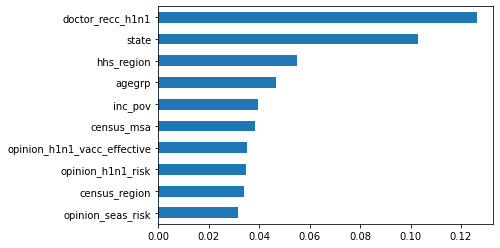

In [34]:
importances.sort_values()[-10:].plot.barh()
plt.show();

어제 사용하지 않았던 feature인 state의 특성 중요도가 높게 나왔다. 그래서 state를 제거하고 모델을 만들어보았다.

In [35]:
features2 = list(X_train_ordinal)
features2.remove("state")

In [36]:
# 모델 생성 및 학습
model_not_state = RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
model_not_state.fit(X_train_ordinal[features2], y_train)

# 결과 확인
print("검증 정확도: ", model_not_state.score(X_val_ordinal[features2], y_val))
print("OOB score: ", model_not_state.oob_score_)

# f1_score 확인
y_pred = model_not_state.predict(X_val_ordinal[features2])
print("검증 f1_score: ", f1_score(y_val, y_pred))

검증 정확도:  0.8102241726960029
OOB score:  0.7986240844527474
검증 f1_score:  0.5192307692307693


state를 사용했을 때보다 score가 낮아졌다.

하이퍼 파리미터 조절해보기

In [37]:
def forest(max_depth=1, n_estimators=1):
  model = RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True,
                                 max_depth=max_depth, n_estimators=n_estimators)
  model.fit(X_train_ordinal, y_train)

  # 결과 확인
  print("검증 정확도: ", model.score(X_val_ordinal, y_val))
  print("OOB score: ", model.oob_score_)

  # f1_score 확인
  y_pred = model.predict(X_val_ordinal)
  print("검증 f1_score: ", f1_score(y_val, y_pred))

In [38]:
forest(max_depth=12, n_estimators=200)

검증 정확도:  0.8195943541691377
OOB score:  0.8109005723096996
검증 f1_score:  0.5509300265721877


하이퍼 파리미터의 값을 변경하니까 정확도와 f1_score 값이 달라졌다.

In [39]:
# 2) count encoder를 사용했을 때

# 모델 생성 및 학습
model_count = RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
model_count.fit(X_train_count, y_train)

# 결과 확인
print("검증 정확도: ", model_count.score(X_val_count, y_val))
print("OOB score: ", model_count.oob_score_)

# f1_score 확인
y_pred = model_count.predict(X_val_count)
print("검증 f1_score: ", f1_score(y_val, y_pred))

검증 정확도:  0.8108172221563278
OOB score:  0.8042285680396168
검증 f1_score:  0.5211648153707595


count encoder를 사용해서 인코딩한 데이터를 가지고 랜덤 포레스트 모델을 만들어보았다. 그랬더니 ordinal encoder를 사용했을 때보다 스코어가 낮아졌다.

최종모델 만들기

In [40]:
X_total = pd.concat([X_train_ordinal, X_val_ordinal])
y_total = pd.concat([y_train, y_val])

In [41]:
# 모델 생성 및 학습하기
model = RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True,
                                 max_depth=12, n_estimators=200)
model.fit(X_total, y_total)

# 결과 확인
print("train 정확도: ", model.score(X_total, y_total))
print("OOB score: ", model.oob_score_)

# f1_score 확인
y_pred = model.predict(X_total)
print("train f1_score: ", f1_score(y_total, y_pred))

train 정확도:  0.8605351805285382
OOB score:  0.8135171039521754
train f1_score:  0.6560982743492249


In [42]:
# 결과 저장
y_pred_test = model.predict(X_test_ordinal)
submission = pd.DataFrame({"Id":range(0, len(X_test_ordinal)), "vacc_h1n1_f": y_pred_test})
submission.to_csv('submission_vacc_n222a.csv', index=False)

어제 submission 결과와 비교

- 어제 score: 0.54886
- 오늘 score: 0.51408

Q) 왜 스코어가 떨어졌을까?

A) 처음에는 과적합 때문인가 하고 생각했는데 랜덤 포레스트 모델이 트리 모델 하나를 쓰는 것보다 과적합이 덜하다는 수업 시간의 설명이 생각났다. 그 다음에 생각난 것은 하이퍼 파라미터를 GridCV등을 이용해서 만든 게 아니라 임으로 변경해가면서 찾았기 때문에, 최적의 값이 아니라 오히려 성능이 더 저하되는 값을 찾은 것이라고 생각했다.

In [43]:
# 모델 생성 및 학습하기
model = RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
model.fit(X_total, y_total)

# 결과 확인
print("train 정확도: ", model.score(X_total, y_total))
print("OOB score: ", model.oob_score_)

# f1_score 확인
y_pred = model.predict(X_total)
print("train f1_score: ", f1_score(y_total, y_pred))

train 정확도:  0.9941879774161408
OOB score:  0.8037671395359871
train f1_score:  0.9878115516640964


In [44]:
# 결과 저장
y_pred_test = model.predict(X_test_ordinal)
submission = pd.DataFrame({"Id":range(0, len(X_test_ordinal)), "vacc_h1n1_f": y_pred_test})
submission.to_csv('submission_vacc_n222a_2.csv', index=False)

위 이유가 맞는지 확인해보고 싶어서 위의 코드처럼 하이퍼 파라미터를 하나도 변경하지 않고 다시 결과를 확인해보았다. 그랬더니 train 데이터셋에 대해서 확인했을 때는 정확도가 올라갔는데, 오히려 submission의 score는 0.49849로 내려갔다.

하이퍼 파라미터도 원인이 아니라면, 전처리를 어제부터 잘못 했는데 오늘 티가 난 것이거나, feature engineering을 할 때 잘못된 변수를 만들어서일 수도 있을 것 같다.

+) pipeline 사용하기

오늘 과제에서는 전처리, 인코딩, 모델 생성 부분의 항목이 나눠져있어서 각 항목의 결과로 만든 데이터프레임을 다음 항목에 사용하면 되어 pipeline을 사용할 필요가 없었다. 그렇지만 아직 pipeline을 사용하는 방법이 손에 익지 않아서 따로 시도해보았다.

In [45]:
from sklearn.pipeline import make_pipeline

# 파이프라인 만들기
# ordinal encoder, RandomForestClassifier
pipe_ord = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="most_frequent"),
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)

# 학습
pipe_ord.fit(X_train, y_train)

# 결과 확인
print("검증 정확도: ", pipe_ord.score(X_val, y_val))
print("OOB score: ", pipe_ord.named_steps["randomforestclassifier"].oob_score_)

# f1_score 확인
y_pred = pipe_ord.predict(X_val)
print("검증 f1_score: ", f1_score(y_val, y_pred))

검증 정확도:  0.8114102716166528
OOB score:  0.8016190730362067
검증 f1_score:  0.5250896057347669


```
검증 정확도:  0.8114102716166528
OOB score:  0.8016190730362067
검증 f1_score:  0.5250896057347669
```
위에서 각 과정을 따로따로 수행했을 때와 결과가 동일하게 나왔다.

## 참고자료

- [Random Forests for Complete Beginners](https://victorzhou.com/blog/intro-to-random-forests/)